In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import autograd.numpy as np
import autograd.scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

import emfathy

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/fits'
save_preprocessed_data = False

orig_reg_params = dict()
reg_params = dict()
datafile = os.path.join(fit_dir, 'transformed_gene_regression_df4_degree3_genes1000.npz')
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    orig_reg_params['beta_mean'] = infile['beta_mean']
    orig_reg_params['beta_info'] = infile['beta_info']
    df = infile['df']
    total_num_genes = infile['y_train'].shape[0] + infile['y_test'].shape[0]
    degree = infile['degree']

    x_train = infile['x']
    y_train = infile['y_train']

#inflate_cov = 1.0
inflate_cov = 0.0

num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

In [3]:
# Shrink the y_info with empirical bayes.

e_tau = reg_params['y_info']
e_log_tau = np.log(reg_params['y_info'])
resid = y_train - np.einsum('ti,ni->nt', x_train, orig_reg_params['beta_mean'])
print(x_train.shape, orig_reg_params['beta_mean'].shape, resid.shape, e_log_tau.shape)


def get_hierarchical_gamma_log_prob(gamma, log_gamma, gamma_shape, gamma_rate):
    # These can cause numerical difficulties, so separate them out
    # for easier debugging.
    t1 = gamma_shape * np.log(gamma_rate)
    t2 = sp.special.gammaln(gamma_shape)
    t3 = (gamma_shape - 1) * log_gamma
    t4 = gamma_rate * gamma
    return np.sum(t1 - t2 + t3 - t4)


def get_regression_log_lik(e_tau, e_log_tau, resid, prior_shape, prior_rate):
    log_lik_by_nt = \
        -0.5 * e_tau[:, None] * (resid ** 2) + 0.5 * e_log_tau[:, None]
    
    return \
        np.sum(log_lik_by_nt) + \
        np.sum(get_hierarchical_gamma_log_prob(e_tau, e_log_tau, prior_shape, prior_rate))


prior_shape = 3.0
prior_rate = 4.0

get_regression_log_lik(e_tau, e_log_tau, resid, prior_shape, prior_rate)

(42, 7) (700, 7) (700, 42) (700,)


-3153.6228921129696

In [4]:
gamma_prior_pattern = paragami.PatternDict()
gamma_prior_pattern['shape'] = paragami.NumericScalarPattern(lb=0.)
gamma_prior_pattern['rate'] = paragami.NumericScalarPattern(lb=0.)

gamma_prior = {'shape': 3.0, 'rate': 4.0}
gamma_prior_pattern.validate_folded(gamma_prior)
def wrap_get_regression_log_lik(e_tau, e_log_tau, gamma_prior):
    return get_regression_log_lik(
        e_tau, e_log_tau, resid, gamma_prior['shape'], gamma_prior['rate'])

wrap_get_regression_log_lik(e_tau, e_log_tau, gamma_prior)

-3153.6228921129696

In [5]:
get_marginal_objective, \
get_gamma_natural_parameters, \
get_gamma_all_parameters, \
get_gamma_entropy_and_parameters = \
    emfathy.em_gamma_lib.get_gamma_e_step_funs(
        wrap_get_regression_log_lik, e_tau.shape)


In [6]:
get_marginal_objective(gamma_prior)

1591.4649893933024

In [7]:
opt_obj = paragami.OptimizationObjective(
    paragami.FlattenFunctionInput(
        lambda x: -1 * get_marginal_objective(x), free=True, patterns=gamma_prior_pattern))
init_x = np.zeros(gamma_prior_pattern.flat_length(free=True))
opt_obj.hessian(init_x)

array([[-228.92165418, -546.15749547],
       [-546.15749547, 2381.58736616]])

In [8]:
import scipy as osp
gamma_prior_opt_result = osp.optimize.minimize(
    opt_obj.f,
    x0=init_x,
    jac=opt_obj.grad,
    hess=opt_obj.hessian,
    method='trust-ncg',
    options={'maxiter': 1000, 'gtol': 1e-8})
gamma_prior_opt = gamma_prior_pattern.fold(gamma_prior_opt_result.x, free=True)

Iter 0: f = -5279.68415870
Iter 1: f = -7182.68172755
Iter 2: f = -7340.98604939
Iter 3: f = -7343.74963305
Iter 4: f = -7345.52575512
Iter 5: f = -7345.52778914
Iter 6: f = -7345.52778915
Iter 7: f = -7345.52778915


In [9]:
# Sanity check the moments.

opt_e_tau, opt_e_log_tau = \
    emfathy.em_gamma_lib.get_gamma_moments_from_standard(
        gamma_prior_opt['shape'], gamma_prior_opt['rate'])
print(opt_e_tau[0],
      np.mean(reg_params['y_info']))

opt_sd_tau = np.sqrt(gamma_prior_opt['shape'][0]) / gamma_prior_opt['rate'][0],
print(opt_sd_tau,
      np.std(reg_params['y_info']))

print(opt_e_log_tau[0],
      np.mean(np.log(reg_params['y_info'])))

6.481564661288157 5.703171285752289
(4.845019345385627,) 4.850246106011231
1.5642778683597043 1.406164073045567


We are effectively shrinking the information quite a lot.

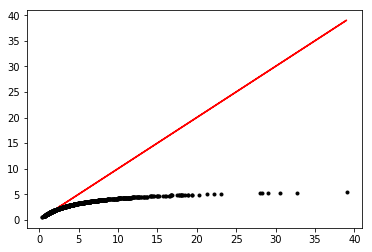

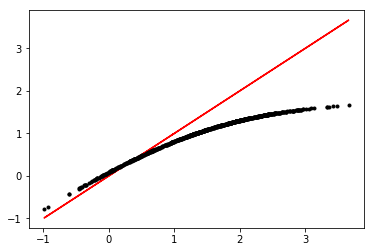

In [10]:
def comparison_plot(x, y):
    plt.plot(x, x, 'r')
    plt.plot(x, y, 'k.')

opt_e_tau, opt_e_log_tau, tau_nat1, tau_nat2 = get_gamma_all_parameters(gamma_prior)
plt.figure()
comparison_plot(reg_params['y_info'], opt_e_tau)
plt.figure()
comparison_plot(np.log(reg_params['y_info']), opt_e_log_tau)

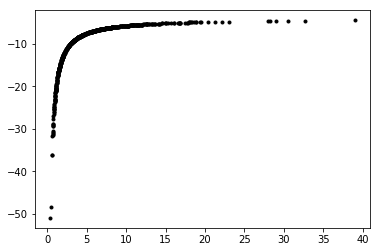

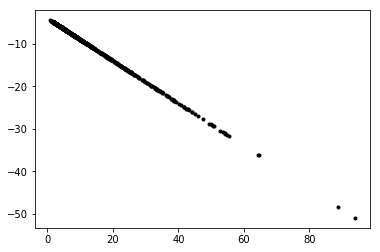

In [11]:
plt.figure()
plt.plot(reg_params['y_info'], tau_nat1, 'k.')
plt.figure()
plt.plot(np.sum(resid ** 2, axis=1), tau_nat1, 'k.');

In [12]:
shrink_factor = opt_e_tau / reg_params['y_info']

new_beta_info = \
    reg_params['beta_info'] * shrink_factor[:, None, None]

if inflate_cov > 0.0:
    # This is totally arbitrary, but it makes for uncertainty in clustering.
    new_beta_cov = np.array([
        np.linalg.inv(new_beta_info[n, :, :])
        for n in range(num_genes)])
    new_beta_info = np.array([
        np.linalg.inv(
            new_beta_cov[n, :, :] +
            inflate_cov * np.eye(obs_dim))
        for n in range(num_genes)])

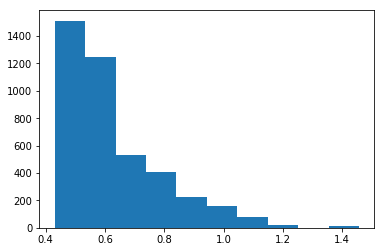

In [13]:
new_beta_cov = np.array([ np.linalg.inv(new_beta_info[n, :, :]) for n in range(num_genes)])
beta_sd = np.array([ np.sqrt(np.diag(new_beta_cov[n, :, :])) for n in range(num_genes)])
plt.figure()
plt.hist(beta_sd.flatten());

In [15]:
new_datafile = os.path.join(
    ('shrunken_transformed_gene_regression_' +
     'df{}_degree{}_genes{}_inflate{}.npz').format(
    df, degree, total_num_genes, inflate_cov))
print('Saving to {}'.format(new_datafile))
new_save_dict = dict()
with np.load(datafile) as infile:
    for k in infile.keys():
        new_save_dict[k] = infile[k]

new_save_dict['y_info'] = opt_e_tau
new_save_dict['transformed_beta_info'] = new_beta_info
new_save_dict['inflate_cov'] = inflate_cov
new_save_dict['eb_shrunk'] = True
np.savez_compressed(new_datafile, **new_save_dict)

Saving to shrunken_transformed_gene_regression_df4_degree3_genes1000_inflate0.0.npz


## Make some nice plots

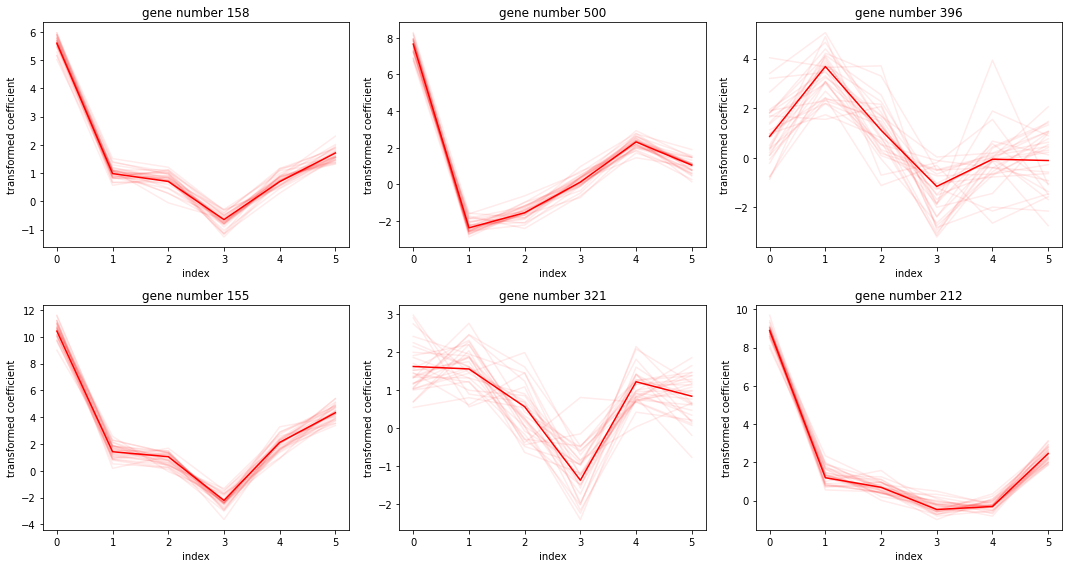

In [20]:
# Sanity check with a figure
f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_reg_params = { 'beta_mean': reg_params['beta_mean'],
                    'beta_info': reg_params['beta_info'] }

num_obs = np.shape(plot_reg_params['beta_mean'])[0]
plot_inds = np.random.choice(num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            reg_params['beta_mean'][n, :], \
             np.linalg.inv(reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

#     k = np.argmax(e_z[n, :])
#     this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()